In this notebook, we propose a demonstration of our reimplementation of Stereoscope in the new scvi-tools codebase. We apply our implementation as well as the original code on 10x Visium data from the hippocampus of a mouse brain. 

# Install scvi-tools

In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]==0.9.0
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 183 kB 5.7 MB/s 
     |████████████████████████████████| 678 kB 40.1 MB/s 
     |████████████████████████████████| 925 kB 25.2 MB/s 
     |████████████████████████████████| 212 kB 38.1 MB/s 
     |████████████████████████████████| 127 kB 38.3 MB/s 
     |████████████████████████████████| 242 kB 38.5 MB/s 
     |████████████████████████████████| 2.0 MB 36.1 MB/s 
     |████████████████████████████████| 1.4 MB 37.2 MB/s 
     |████████████████████████████████| 41 kB 68 kB/s 
     |████████████████████████████████| 3.2 MB 10.5 MB/s 
     |████████████████████████████████| 8.8 MB 24.6 MB/s 
     |████████████████████████████████| 48 kB 5.1 MB/s 
     |████████████████████████████████| 829 kB 40.2 MB/s 
     |████████████████████████████████| 636 kB 38.4 MB/s 
     |████████████████████████████████| 125 kB 48.7 MB/s 
     |████████████████████████████████| 282 kB 41.8 MB/s 
     |████████████████████████████████| 1.3 MB 38.9 MB/s 
     |██████████████

# Get the single-cell data

In [2]:
!wget https://github.com/YosefLab/scVI-data/blob/master/scRefSubsampled1000_hippocampus_compressed.h5ad?raw=true -O scRef.h5ad

--2021-10-08 22:44:13--  https://github.com/YosefLab/scVI-data/blob/master/scRefSubsampled1000_hippocampus_compressed.h5ad?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YosefLab/scVI-data/raw/master/scRefSubsampled1000_hippocampus_compressed.h5ad [following]
--2021-10-08 22:44:13--  https://github.com/YosefLab/scVI-data/raw/master/scRefSubsampled1000_hippocampus_compressed.h5ad
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YosefLab/scVI-data/master/scRefSubsampled1000_hippocampus_compressed.h5ad [following]
--2021-10-08 22:44:13--  https://raw.githubusercontent.com/YosefLab/scVI-data/master/scRefSubsampled1000_hippocampus_compressed.h5ad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.1

# Import libraries

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [4]:
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

# Read Spatial transcriptomics data

In [5]:
st_adata = sc.datasets.visium_sge(sample_id="V1_Adult_Mouse_Brain")
st_adata.var_names_make_unique()

  0%|          | 0.00/8.62M [00:00<?, ?B/s]

  0%|          | 0.00/20.1M [00:00<?, ?B/s]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


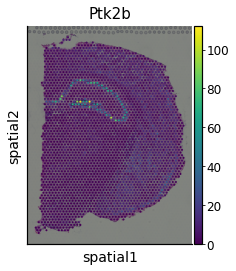

In [6]:
sc.pl.spatial(st_adata, img_key="hires", color=["Ptk2b"])

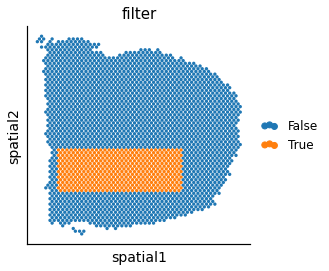

In [7]:
# Take a slice and focus on the hippocampus
sl_adata = st_adata[st_adata.obs["array_row"] > 15]
sl_adata = sl_adata[sl_adata.obs["array_row"] < 32]
sl_adata = sl_adata[sl_adata.obs["array_col"] > 20]
sl_adata = sl_adata[sl_adata.obs["array_col"] < 80]

st_adata.obs["filter"] = pd.Categorical([x in sl_adata.obs.index for x in st_adata.obs.index])
sc.pl.embedding(st_adata, basis="spatial", color="filter")

Marker genes
+ CA1: Fibcd1
+ CA3: Npy2r
+ Dentate: Prox1
+ Oligo: Plp1
+ Astrocytes: Aldoc

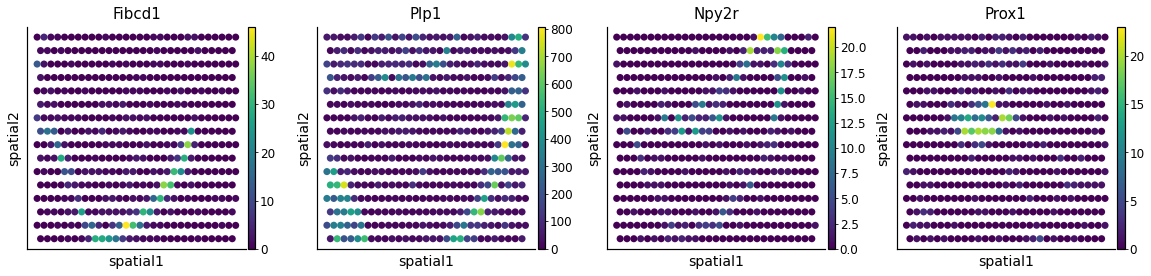

In [8]:
sc.pl.embedding(sl_adata, basis="spatial", color=["Fibcd1", "Plp1", "Npy2r", "Prox1"], size=200)

# Read single-cell RNA Sequencing data

In [9]:
sc_adata = sc.read_h5ad("scRef.h5ad")
sc_adata.obs["liger_ident_coarse"].value_counts()

Polydendrocyte           1000
Oligodendrocyte          1000
CA1                      1000
CA3                      1000
Denate                   1000
Endothelial_Stalk        1000
Entorihinal              1000
Interneuron              1000
Microglia_Macrophages    1000
Mural                    1000
Neuron.Slc17a6           1000
Astrocyte                1000
Neurogenesis              988
Ependymal                 715
Endothelial_Tip           676
Cajal_Retzius             672
Choroid                    44
Name: liger_ident_coarse, dtype: int64

In [10]:
# preprocessing
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata.layers["counts"] = sc_adata.X.copy()
# normalization for selection of highly variable genes (not for the deconvolution)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
sl_adata = sl_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [11]:
# visualize for fun
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(sc_adata)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


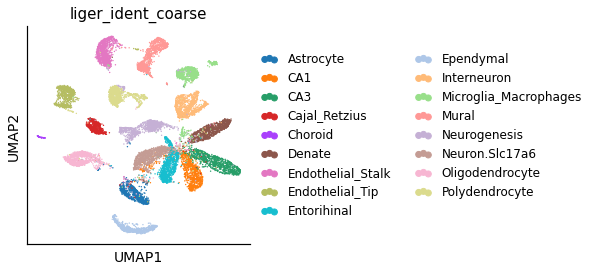

In [12]:
sc.pl.umap(sc_adata, color=['liger_ident_coarse'])

In [13]:
# restore counts for CLI Stereoscope 
sc_adata.X = sc_adata.layers["counts"].copy()

# Learn RNA model (on scRNA-seq data)

In [14]:
import scvi
from scvi.external.stereoscope import RNAStereoscope, SpatialStereoscope

In [15]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="liger_ident_coarse")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["liger_ident_coarse"]                                   
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 15095 cells, 1898 vars, 1 batches,
         17 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/75000:  -0%|          | -1/75000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:536: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)


Epoch 124/75000:   0%|          | 123/75000 [04:09<41:46:28,  2.01s/it, loss=437, v_num=1]


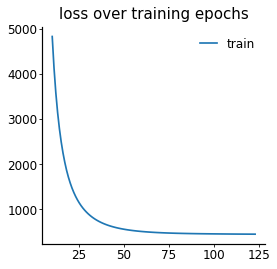

In [98]:
# time per epoch on colab for this is 2.15 seconds per epoch
# original implementation recommends 75,000 epochs. That would take 44 hours with our code.
# early stopping stopped at 124 epochs!
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    # here we use "weight_decay=0" to reproduce Stereoscope, but we advise to use the default parameter for all other applications
    sc_model.train(max_epochs=75000, plan_kwargs={"weight_decay": 0}, check_val_every_n_epoch=1, train_size=0.9, validation_size=0.1,
                   early_stopping=True, early_stopping_monitor="elbo_validation", early_stopping_patience=5, early_stopping_min_delta=1)
    plt.plot(sc_model.history["elbo_train"][10:], label="train")
    plt.title("loss over training epochs")
    plt.legend()
    plt.show()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", sc_adata)
    print("Loaded RNA model from file!")

small detour to get the gene by cell type matrix for the figure

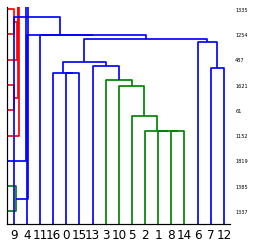

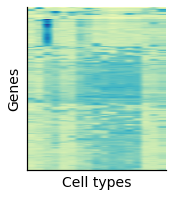

In [ ]:
params = sc_model.module.get_params()

import scipy.cluster.hierarchy as sch

Y = sch.linkage(params[0], method="centroid")
Z1 = sch.dendrogram(Y, orientation="left")
X = sch.linkage(params[0].T, method="single")
Z2 = sch.dendrogram(X)

# .matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
plt.figure(figsize=(3, 3))
plt.imshow(params[0][Z1["leaves"]][:, Z2["leaves"]][:200], aspect=0.1, cmap="YlGnBu")
plt.gca().axes.xaxis.set_ticks([])
plt.gca().axes.yaxis.set_ticks([])
plt.xlabel("Cell types")
plt.ylabel("Genes")
plt.savefig("dict_gene_exp.pdf")
plt.show()

We can check that marker genes have high value of the parameters in the single-cell model. For example, a CA1 marker. Check that the parameter of the marker gene is larger for the CA1 cell type!

In [ ]:
list(zip(sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"], params[0][np.where(sc_adata.var_names == "Fibcd1")[0][0],]))

[('Astrocyte', -5.2626896),
 ('CA1', -0.4624054),
 ('CA3', -4.712559),
 ('Cajal_Retzius', -3.570729),
 ('Choroid', -4.62259),
 ('Denate', -3.7888067),
 ('Endothelial_Stalk', -5.159405),
 ('Endothelial_Tip', -4.8515234),
 ('Entorihinal', -4.4005585),
 ('Ependymal', -5.4058185),
 ('Interneuron', -4.5235586),
 ('Microglia_Macrophages', -4.381595),
 ('Mural', -4.8622494),
 ('Neurogenesis', -5.2961636),
 ('Neuron.Slc17a6', -4.4431376),
 ('Oligodendrocyte', -5.39666),
 ('Polydendrocyte', -4.1047277)]

In [ ]:
list(zip(sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"], params[0][np.where(sc_adata.var_names == "Fibcd1")[0][0],]))

[('Astrocyte', -5.2626896),
 ('CA1', -0.4624054),
 ('CA3', -4.712559),
 ('Cajal_Retzius', -3.570729),
 ('Choroid', -4.62259),
 ('Denate', -3.7888067),
 ('Endothelial_Stalk', -5.159405),
 ('Endothelial_Tip', -4.8515234),
 ('Entorihinal', -4.4005585),
 ('Ependymal', -5.4058185),
 ('Interneuron', -4.5235586),
 ('Microglia_Macrophages', -4.381595),
 ('Mural', -4.8622494),
 ('Neurogenesis', -5.2961636),
 ('Neuron.Slc17a6', -4.4431376),
 ('Oligodendrocyte', -5.39666),
 ('Polydendrocyte', -4.1047277)]

# Infer proportion for spatial data



In [19]:
sl_adata.layers["counts"] = sl_adata.X.copy()
scvi.data.setup_anndata(sl_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 472 cells, 1898 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 3/75000:   0%|          | 1/75000 [00:00<1:38:14, 12.72it/s, loss=1.7e+06, v_num=1]

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:536: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)


Epoch 4219/75000:   6%|▌         | 4218/75000 [06:28<1:48:39, 10.86it/s, loss=2.65e+05, v_num=1]


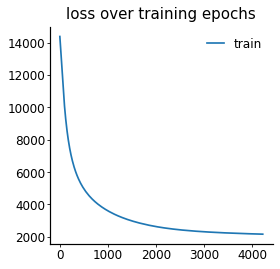

In [119]:
# time per epoch on colab for this is 0.09 seconds per epoch
# original implementation uses 75,000 epochs, that would take 1.8 hours with this code
# early stopping stopped at 
train = True
if train:
    # here we use "minibatch" to reproduce Stereoscope, but we advise to use the default parameter for all other applications
    # here we use "weight_decay=0" to reproduce Stereoscope, but we advise to use the default parameter for all other applications
    spatial_model = SpatialStereoscope.from_rna_model(
        sl_adata, sc_model, prior_weight="minibatch"
    )
    spatial_model.train(max_epochs=75000, plan_kwargs={"weight_decay": 0}, check_val_every_n_epoch=1, early_stopping=True, 
                        early_stopping_monitor="elbo_train", early_stopping_patience=5, early_stopping_min_delta=0.4)
    plt.plot(spatial_model.history["elbo_train"], label="train")
    plt.title("loss over training epochs")
    plt.legend()
    plt.show()
    spatial_model.save("stmodel", overwrite=True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", sl_adata)
    print("Loaded Spatial model from file!")

In [121]:
spatial_model.history["elbo_train"][-20:]

,elbo_train
epoch,
4199,2169.14
4200,2169.07
4201,2168.98
4202,2168.91
4203,2168.83
4204,2168.74
4205,2168.66
4206,2168.58
4207,2168.5


In [122]:
sl_adata.obsm["deconvolution"] = spatial_model.get_proportions()

In [123]:
for ct in sl_adata.obsm["deconvolution"].columns:
    sl_adata.obs[ct] = sl_adata.obsm["deconvolution"][ct]

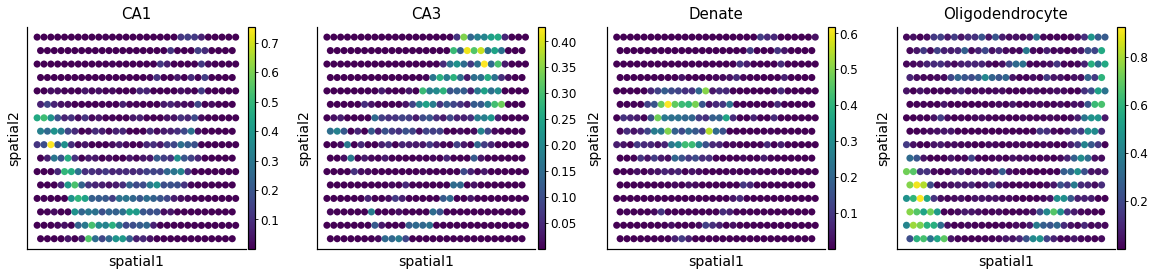

In [124]:
sc.pl.embedding(sl_adata, basis="spatial", color=["CA1", "CA3", "Denate", "Oligodendrocyte"], size=200)

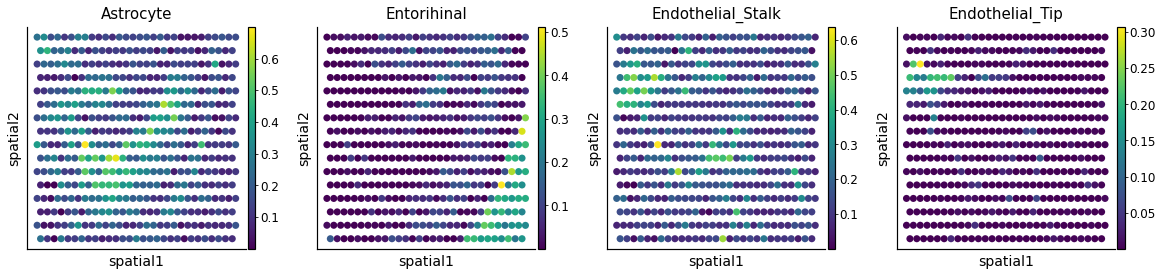

In [125]:
sc.pl.embedding(sl_adata, basis="spatial", color=["Astrocyte", "Entorihinal", "Endothelial_Stalk", "Endothelial_Tip"], size=200)

In [110]:
sl_adata.obsm["deconvolution"].columns

Index(['Astrocyte', 'CA1', 'CA3', 'Cajal_Retzius', 'Choroid', 'Denate',
       'Endothelial_Stalk', 'Endothelial_Tip', 'Entorihinal', 'Ependymal',
       'Interneuron', 'Microglia_Macrophages', 'Mural', 'Neurogenesis',
       'Neuron.Slc17a6', 'Oligodendrocyte', 'Polydendrocyte'],
      dtype='object')

small detour to get a nice plot for the paper

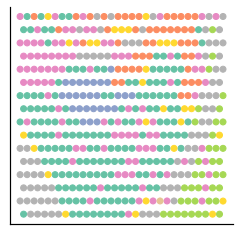

In [ ]:
plt.scatter(sl_adata.obsm["spatial"][:, 0],  sl_adata.obsm["spatial"][:, 1], c=sl_adata.obsm["deconvolution"].values.argmax(1), cmap="Set2")
# cmap="YlGnBu")
plt.gca().axes.xaxis.set_ticks([])
plt.gca().axes.yaxis.set_ticks([])
# plt.xlabel("Cell types")
# plt.ylabel("Genes")
plt.savefig("cell_type_location.pdf")


Save files for input to original Stereoscope

In [35]:
del sl_adata.obs["filter"]
sl_adata.write_h5ad("sl_adata.h5ad")
sc_adata.write_h5ad("sc_adata.h5ad")

# Install Stereoscope from source

In [36]:
# must use my own fork because of circular dependencies in the original codebase that didn't work out for Colab (unknown reason; only two import lines deleted)
!git clone https://github.com/romain-lopez/stereoscope 

Cloning into 'stereoscope'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 574 (delta 139), reused 172 (delta 63), pack-reused 308
Receiving objects: 100% (574/574), 57.61 MiB | 31.50 MiB/s, done.
Resolving deltas: 100% (292/292), done.


In [37]:
%%capture
!cd stereoscope; ./setup.py install

In [38]:
!python -c "import stsc; print(stsc.__version__)"
!stereoscope test

stereoscope : 0.2.0


# Run Stereoscope & read results

In [39]:
# SCMODEL: time per epoch on colab for this is 1.8 seconds per epoch
# original implementation uses 75,000 epochs, that would take 37.5 hours

# STMODEL: time per epoch on colab for this is 0.036 seconds per epoch
# original implementation uses 75,000 epochs, that would take 45 min
!stereoscope run --sc_cnt sc_adata.h5ad --label_colname liger_ident_coarse --st_cnt sl_adata.h5ad \
-sce 100  -o stereo-out -n 2000 -ste 5000 --gpu -stb 128 -scb 128

[2021-10-08 23:16:21,587 - stsc - INFO ] >> Using device cuda
[2021-10-08 23:16:21,587 - stsc - INFO ] >> fitting sc data | count file : sc_adata.h5ad | labels file : None
[2021-10-08 23:16:22,164 - stsc - INFO ] >> SC data GENES : 1898  SC data CELLS : 15095  SC data TYPES : 17 


Epoch : 100/100 | Loss : 6.784156E+06 | [ =================== ] 

[2021-10-08 23:18:19,979 - stsc - INFO ] >> fit st data section(s) : ['sl_adata.h5ad']
[2021-10-08 23:18:20,100 - stsc - INFO ] >> ST data GENES : 1898  ST data SPOTS : 472 


Epoch : 5000/5000 | Loss : 1.033198E+06 | [ =================== ] 

[2021-10-08 23:20:17,653 - stsc - INFO ] >> saving proportions for section sl_adata to stereo-out/sl_adata/W.2021-10-08231621.578106.tsv


In [66]:
# second run for assessing stochasticity reproducibility
!stereoscope run --sc_cnt sc_adata.h5ad --label_colname liger_ident_coarse --st_cnt sl_adata.h5ad \
-sce 100  -o stereo-out-2 -n 2000 -ste 5000 --gpu -stb 128 -scb 128

[2021-10-08 23:30:36,009 - stsc - INFO ] >> Using device cuda
[2021-10-08 23:30:36,010 - stsc - INFO ] >> fitting sc data | count file : sc_adata.h5ad | labels file : None
[2021-10-08 23:30:36,577 - stsc - INFO ] >> SC data GENES : 1898  SC data CELLS : 15095  SC data TYPES : 17 


Epoch : 100/100 | Loss : 6.768616E+06 | [ =================== ] 

[2021-10-08 23:32:30,233 - stsc - INFO ] >> fit st data section(s) : ['sl_adata.h5ad']
[2021-10-08 23:32:30,345 - stsc - INFO ] >> ST data GENES : 1898  ST data SPOTS : 472 


Epoch : 5000/5000 | Loss : 1.032892E+06 | [ =================== ] 

[2021-10-08 23:34:26,866 - stsc - INFO ] >> saving proportions for section sl_adata to stereo-out-2/sl_adata/W.2021-10-08233035.999024.tsv


In [67]:
import os
path = "stereo-out/sl_adata/"
stereo_out = pd.read_csv(path+os.listdir(path)[0],  sep="\t", index_col=0)
stereo_out.index = sl_adata.obs.index.copy()

path = "stereo-out-2/sl_adata/"
stereo_out_2 = pd.read_csv(path+os.listdir(path)[0],  sep="\t", index_col=0)
stereo_out_2.index = sl_adata.obs.index.copy()

In [68]:
def prettify_axis(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [126]:
from scipy.stats import spearmanr, pearsonr
scores_spearman = []
scores_pearson = []

for i, ct in enumerate(sl_adata.obsm["deconvolution"].columns):
    data = sl_adata.obsm["deconvolution"][ct]
    scores_spearman.append(spearmanr(data, stereo_out[ct]).correlation)
    scores_pearson.append(pearsonr(data, stereo_out[ct])[0])

scores_spearman_2 = []
scores_pearson_2 = []

for i, ct in enumerate(sl_adata.obsm["deconvolution"].columns):
    data = stereo_out_2[ct]
    scores_spearman_2.append(spearmanr(data, stereo_out[ct]).correlation)
    scores_pearson_2.append(pearsonr(data, stereo_out[ct])[0])

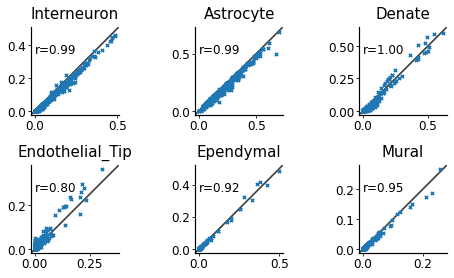

In [127]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4))
indices = [11, 10, 4]
for i, ct in enumerate(["Interneuron", "Astrocyte", "Denate"]):
    prettify_axis(axs[0, i])
    axs[0, i].scatter(
        sl_adata.obsm["deconvolution"][ct], stereo_out[ct], marker="x", s=10
    )
    ax = axs[0, i]
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    axs[0, i].set_title(ct)
    axs[0, i].text(
        0.05,
        0.7,
        "r=" + "{:0.2f}".format(scores_spearman[indices[i]]),
        fontsize=12,
        transform=axs[0, i].transAxes,
    )
    axs[0, i].set_aspect("equal", adjustable="box")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    # axs[i].plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), c="black")
indices = [7, 9, 12]
for i, ct in enumerate(["Endothelial_Tip", "Ependymal", "Mural"]):
    prettify_axis(axs[1, i])
    axs[1, i].scatter(
        sl_adata.obsm["deconvolution"][ct], stereo_out[ct], marker="x", s=10
    )
    ax = axs[1, i]
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    axs[1, i].set_title(ct)
    axs[1, i].text(
        0.05,
        0.7,
        "r=" + "{:0.2f}".format(scores_spearman[indices[i]]),
        fontsize=12,
        transform=axs[1, i].transAxes,
    )
    axs[1, i].set_aspect("equal", adjustable="box")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    # axs[i].plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), c="black")
plt.tight_layout()
plt.savefig("stereoscope_scatter.pdf", bbox_inches="tight", dpi=DPI)
plt.show()

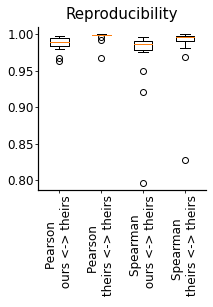

In [128]:
# the order of the three less reproducible cell types is the same (7, 9, 12) <-> (Endothelial_Tip, Ependymal, Mural) 
# the first two of those list are among the least present in the scRNA-seq
plt.figure(figsize=(3, 3))
plt.boxplot([scores_pearson, scores_pearson_2, scores_spearman, scores_spearman_2])
plt.xticks([1, 2, 3, 4], ['Pearson \n ours <-> theirs', 'Pearson \n theirs <-> theirs', 'Spearman \n ours <-> theirs', 'Spearman \n theirs <-> theirs',], rotation=90)
# plt.ylim((0, 1.1))
plt.title("Reproducibility")
plt.savefig("stereoscope_box.pdf", bbox_inches="tight", dpi=DPI)
plt.show()

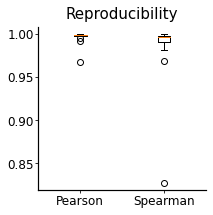

In [72]:
plt.figure(figsize=(3, 3))
plt.boxplot()
plt.xticks([1, 2], ['Pearson', 'Spearman'])
# plt.ylim((0, 1.1))
plt.title("Reproducibility")
plt.savefig("stereoscope_box.pdf", bbox_inches="tight", dpi=DPI)
plt.show()

In [64]:
np.argsort(scores_spearman)

array([ 7,  9, 12, 13,  5,  2,  1, 16,  3, 14,  6,  8, 11, 15,  0, 10,  4])

In [82]:
np.argsort(scores_spearman_2)

array([ 7,  9, 12, 16, 13,  5,  2,  6,  3,  1, 14,  8, 15,  0, 10, 11,  4])

In [85]:
sl_adata.obsm["deconvolution"].columns[12]

'Mural'

In [65]:
scores_spearman

[0.9980070292616585,
 0.9891878142118535,
 0.9788866524139894,
 0.9896832039264173,
 0.9988470577548406,
 0.9783361433186067,
 0.9958836207339256,
 0.864994719723084,
 0.99613297031382,
 0.8962925996924728,
 0.99847845402804,
 0.9965733547663658,
 0.9204362579167066,
 0.9712670541988988,
 0.9914704184667956,
 0.9965832831020414,
 0.9895800405304336]